In [ ]:
# default_exp modelling

In [ ]:
from theonerig.core import *
from theonerig.processing import *
from theonerig.utils import *
from theonerig.plotting import *

In [ ]:
#export
import math
import scipy as sp
import scipy.optimize
import numpy as np

In [ ]:
#export
_default_sigmoid_p = (1,1,0,0)
def sigmoid(x, sigma, amp, x0, y0):
    """Sigmoid function
    params:
        - x: 1D numpy array at which to evaluate the points
        - sigma: steepness of the sigmoid
        - amp: amplitude of the sigmoid
        - x0: shift in x of the sigmoid
        - y0: shift in y of the sigmoid
    """
    return amp / (1.0 + np.exp(-sigma*(x-x0))) + y0

_default_gaussian_p = (1,1,0,0)
def gaussian(x, sigma, amp, x0, y0):
    """Gaussian function
    params:
        - x: 1D numpy array at which to evaluate the points        
        - sigma: width of the gaussian
        - amp: amplitude of the gaussian
        - x0: shift in x of the gaussian
        - y0: shift in y of the gaussian
    """
    return amp * np.exp(-(x-x0)**2 / (2*sigma**2)) + y0

_default_2Dgaussian_p = (1,1,1,0,0,0,0)
def gaussian_2D(xz, sigma_x, sigma_z, amp, theta, x0, z0, y0):
    """Two dimensional Gaussian function
    params:
        - xz: meshgrid of x and z coordinates at which to evaluate the points
        - sigma_x: width of the gaussian
        - sigma_z: height of the gaussian
        - amp: amplitude of the gaussian
        - theta: angle of the gaussian (in radian)
        - x0: shift in x of the gaussian
        - z0: shift in z of the gaussian
        - y0: shift in y of the gaussian
    """
    (x,z) = xz
    x0, z0 = float(x0), float(z0)
    a =  (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_z**2)
    b = -(np.sin(2*theta)) /(4*sigma_x**2) + (np.sin(2*theta)) /(4*sigma_z**2)
    c =  (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_z**2)
    g = amp * np.exp( -(a*((x-x0)**2) + 2*b*(x-x0)*(z-z0) + c*((z-z0)**2))) + y0
    return g.ravel()

def sum_of_gaussian(t, sigma_1, amp_1, x0_1, 
                       sigma_2, amp_2, x0_2, y0):
    return (gaussian(t, sigma_1, amp_1, x0_1, 0) 
            + gaussian(t, sigma_2, amp_2, x0_2, 0) + y0)

def sum_of_2D_gaussian(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0):
    return (gaussian_2D(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, 0) 
            + gaussian_2D(xz, sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, 0) + y0)


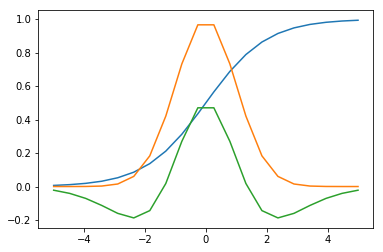

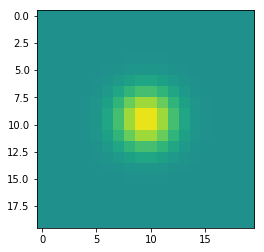

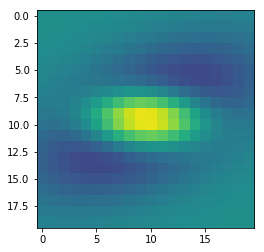

In [ ]:
import matplotlib.pyplot as plt
len_ = 20
x = np.linspace(-5,5,len_)
plt.figure()
plt.plot(x, sigmoid(x,*_default_sigmoid_p))
plt.plot(x, gaussian(x,*_default_gaussian_p))
plt.plot(x, sum_of_gaussian(x, 1,1,0,  2,-.5,0, 0))

xz = np.meshgrid(x,x)
plt.figure()
plt.imshow(gaussian_2D(xz, *_default_2Dgaussian_p).reshape(len_,len_), vmin=-1, vmax=1)
plt.figure()
plt.imshow(sum_of_2D_gaussian(xz, 2,1,2,0,0,0,
                                  2,4,-1,2,0,0, 0).reshape(len_,len_), vmin=-1, vmax=1)


In [ ]:
#export
def fit_nonlinearity(x, nonlin):
    try:
        fit, _ = sp.optimize.curve_fit(sigmoid, x, nonlin)
    except RuntimeError:
        res = {"sigma":1, "amp":0, "x0":0, "y0":0}
    res = {"sigma":fit[0], "amp":fit[1], "x0":fit[2], "y0":fit[3]}
    return res

def fit_spatial_sta(sta):
    shape_y, shape_x = sta.shape
    eps = 0.000001
    argmax = np.unravel_index(sta.argmax(), sta.shape)
    argmin = np.unravel_index(sta.argmin(), sta.shape)
    #                   sigma_x    sigma_z   amp theta      x0        z0      y0
    bounds_center   = ((0,         0,         0,  0,         0,       0,       0),
                       (shape_x*4, shape_y*4, 2,  2*math.pi, shape_x, shape_y, eps))
    if sta[argmax] < abs(sta[argmin]):
        argmax, argmin  = argmin, argmax
        bounds_center   = ((0,         0,        -2,  0,         0,       0,       0),
                           (shape_x*4, shape_y*4, 0,  2*math.pi, shape_x, shape_y, eps))
                       
    x    = np.arange(shape_x)
    z    = np.arange(shape_y)
    x, z = np.meshgrid(x, z)
    #                   sigma_x sigma_z  amp        theta      x0        z0       y0
    init_fit_center   = (  1,     1,    sta[argmax],  0,   argmax[1],  argmax[0], 0)
    data_tofit          = sta.reshape(-1)
    if np.isnan(sp.sum(sta)): #We check that the sta exists, otherwise return default zero model
        res  = {"sigma_x_1": 1, "sigma_z_1":1, "amp_1":0, "theta_1":0, "x0_1":0, "z0_1":0,
                "sigma_x_2": 1, "sigma_z_2":1, "amp_2":0, "theta_2":0, "x0_2":0, "z0_2":0, "y0":0}
    else:
        try:
            fit_c, _   = sp.optimize.curve_fit(gaussian_2D, (x,z), data_tofit, p0=init_fit_center, bounds=bounds_center)
            tmp_to_fit =  data_tofit - gaussian_2D((x,z), *fit_c)
            #                   sigma_x    sigma_z   amp theta        x0            z0           y0
            bounds_surround = ((0,         0,        -2,  0,         fit_c[4],     fit_c[5],     0),
                               (shape_x*4, shape_y*4, 0,  2*math.pi, fit_c[4]+eps, fit_c[5]+eps, eps))
            init_fit_surround = (  2,      2,         0,  0,         fit_c[4],     fit_c[5],     0)
            fit_s, _   = sp.optimize.curve_fit(gaussian_2D, (x,z), tmp_to_fit, p0=init_fit_surround, bounds=bounds_surround)
                       
            init_fit_sum = (*fit_c[:-1],*fit_s[:-1],0)
            #Bounding only the position, that center fit should have found
            bounds_sum   = ((-np.inf,-np.inf,-np.inf,-np.inf,fit_c[4],fit_c[5],
                             -np.inf,-np.inf,-np.inf,-np.inf,fit_c[4],fit_c[5],-np.inf),
                            (np.inf, np.inf, np.inf, np.inf, fit_s[4]+eps,fit_s[5]+eps,
                             np.inf,np.inf,np.inf,np.inf,fit_s[4]+eps,fit_s[5]+eps,np.inf))
            fit_sum, _ = sp.optimize.curve_fit(sum_of_2D_gaussian, (x,z), data_tofit, p0=init_fit_sum, bounds=bounds_sum)
            res  = {"sigma_x_1": fit_sum[0], "sigma_z_1":fit_sum[1], "amp_1":fit_sum[2], 
                    "theta_1":fit_sum[3], "x0_1":fit_sum[4], "z0_1":fit_sum[5],
                    "sigma_x_2": fit_sum[6], "sigma_z_2":fit_sum[7], "amp_2":fit_sum[8], 
                    "theta_2":fit_sum[9], "x0_2":fit_sum[10], "z0_2":fit_sum[11], "y0":fit_sum[12]}

        except RuntimeError: #If a model can't be fitted, we get a runtimeError
            res  = {"sigma_x_1": 1, "sigma_z_1":1, "amp_1":0, "theta_1":0, "x0_1":0, "z0_1":0,
                    "sigma_x_2": 1, "sigma_z_2":1, "amp_2":0, "theta_2":0, "x0_2":0, "z0_2":0, "y0":0}

    return res


In [ ]:
from os.path import join
import matplotlib.pyplot as plt
vivo_2p_dir = "./files/vivo_2p"
reM = import_record(join(vivo_2p_dir, "record_master.h5"))
pipe = Data_Pipe(reM, ["checkerboard", "eye_tracking", "S_matrix"], ["stim_inten", "eye_track", "spike_counts"])
pipe += "checkerboard"
result_sta = process_sta_batch(eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"]), 
                               pipe[0]["spike_counts"], Hw=40)

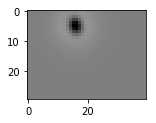

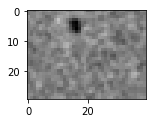

In [ ]:
sta = result_sta[0]
sta_to_fit = peak_sta_frame(sta)
fit = fit_spatial_sta(sta_to_fit)
x    = np.arange(sta.shape[2])
z    = np.arange(sta.shape[1])
x, z = np.meshgrid(x, z)

plot_2d_sta(sum_of_2D_gaussian((x,z), **fit).reshape(sta.shape[1],sta.shape[2]))
plot_2d_sta(sta_to_fit)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted index.ipynb.
